In [3]:
import numpy as np
import pandas as pd
import pyjags
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [5]:
y_train = train['Survived']
X_train = train[['Pclass']]
X_train['Age'] = train['Age'].fillna(np.mean(train['Age']))
X_train['Sex'] = pd.Categorical(train['Sex']).codes
X_train['SibSp_log'] = train.apply(lambda row: math.log(row['SibSp'] + 1), axis=1)

X_test = test[['Pclass']]
X_test['Age'] = test['Age'].fillna(np.mean(test['Age']))
X_test['Sex'] = pd.Categorical(test['Sex']).codes
X_test['SibSp_log'] = test.apply(lambda row: math.log(row['SibSp'] + 1), axis=1)

/home/evgeny/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/evgeny/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/evgeny/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [6]:
X_train.head()

,Pclass,Age,Sex,SibSp_log
0,3,22.0,1,0.693147
1,1,38.0,0,0.693147
2,3,26.0,0,0.000000
3,1,35.0,0,0.693147
4,3,35.0,1,0.000000


In [22]:
code = '''
model {
    for (i in 1:length(y)) {
        y[i] ~ dbern(p[i])
        grp[i] = 3 * Sex[i] + Pclass[i]
        logit(p[i]) = alpha1[Sex[i]+1] + alpha2[grp[i]] + beta[grp[i]]*Age[i] + gamma[grp[i]]*SibSp_log[i]
    }
        
    alpha1[1] ~ dnorm(0.0, 1.0/1.0e6)
    alpha1[2] ~ dnorm(0.0, 1.0/1.0e6) 
    
    alpha2[1] ~ dgamma(r0, lambda0) 
    alpha2[2] ~ dgamma(r0, lambda0) 
    alpha2[3] ~ dgamma(r0, lambda0) 

    alpha2[4] ~ dgamma(r1, lambda1) 
    alpha2[5] ~ dgamma(r1, lambda1) 
    alpha2[6] ~ dgamma(r1, lambda1) 

    for (j in 1:6) {        
        beta[j] ~ dnorm(mu_b, prec_b)
        gamma[j] ~ dnorm(mu_g, prec_g)
    }
    
    mu_b ~ dnorm(0, 1.0/1.0e6)
    prec_b ~ dgamma(1.0, 1.0)
    
    mu_g ~ dnorm(0, 1.0/1.0e6)
    prec_g ~ dgamma(1.0, 1.0)    
    
    r0 ~ dgamma(1.0, 1.0)
    lambda0 ~ dgamma(1.0, 1.0)
    
    r1 ~ dgamma(1.0, 1.0)
    lambda1 ~ dgamma(1.0, 1.0) 
}
'''

In [23]:
data = dict(
    y = y_train, 
    Sex = X_train['Sex'], 
    Pclass = X_train['Pclass'], 
    Age = X_train['Age'], 
    SibSp_log = X_train['SibSp_log'])

In [24]:
model = pyjags.Model(code, data=data, chains=4)
samples = model.sample(15000, vars=['alpha1', 'alpha2', 'beta', 'gamma'])

adapting: iterations 1636 of 4000, elapsed 0:00:05, remaining 0:00:08
adapting: iterations 3124 of 4000, elapsed 0:00:11, remaining 0:00:03
adapting: iterations 4000 of 4000, elapsed 0:00:14, remaining 0:00:00
sampling: iterations 2640 of 60000, elapsed 0:00:09, remaining 0:03:23
sampling: iterations 4052 of 60000, elapsed 0:00:14, remaining 0:03:18
sampling: iterations 5464 of 60000, elapsed 0:00:19, remaining 0:03:13
sampling: iterations 6872 of 60000, elapsed 0:00:24, remaining 0:03:09
sampling: iterations 8276 of 60000, elapsed 0:00:30, remaining 0:03:05
sampling: iterations 9672 of 60000, elapsed 0:00:35, remaining 0:03:02
sampling: iterations 12432 of 60000, elapsed 0:00:45, remaining 0:02:51
sampling: iterations 15208 of 60000, elapsed 0:00:55, remaining 0:02:41
sampling: iterations 17988 of 60000, elapsed 0:01:04, remaining 0:02:30
sampling: iterations 20784 of 60000, elapsed 0:01:14, remaining 0:02:20
sampling: iterations 22184 of 60000, elapsed 0:01:19, remaining 0:02:15
samp

In [28]:
def draw(samples, name, h, w, n):
    print(name)
    f, axarr = plt.subplots(h, w)
    f.set_size_inches(15, 15)
    for i in range(n):
        axarr[i // w, i % w].plot(samples[name][i])
    plt.show()

alpha1


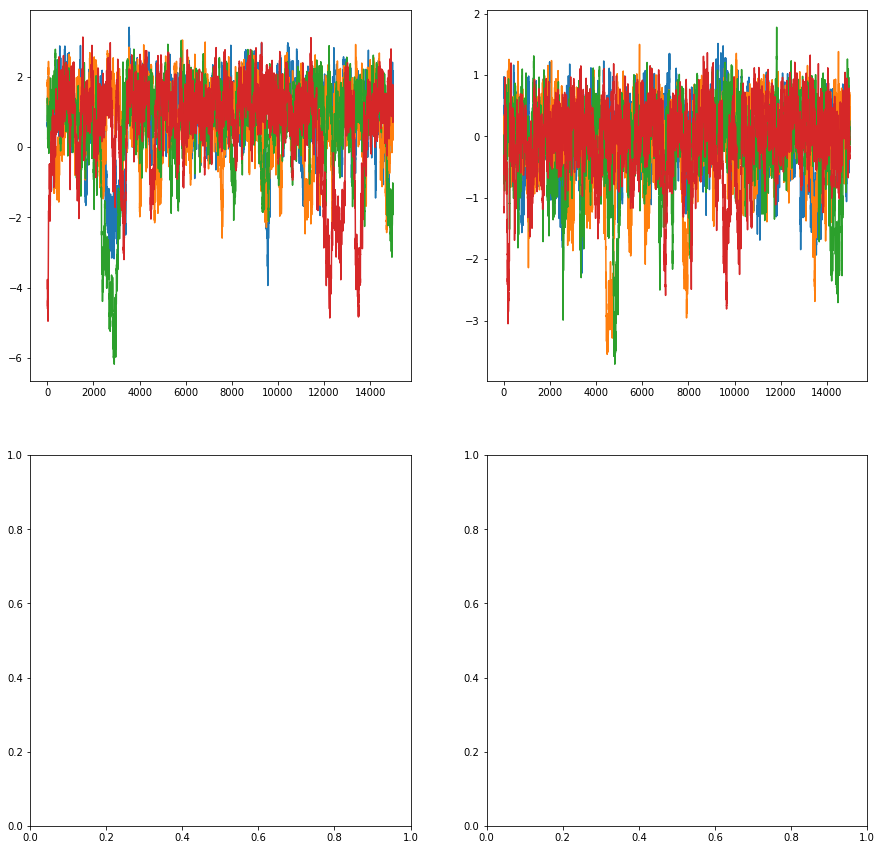

alpha2


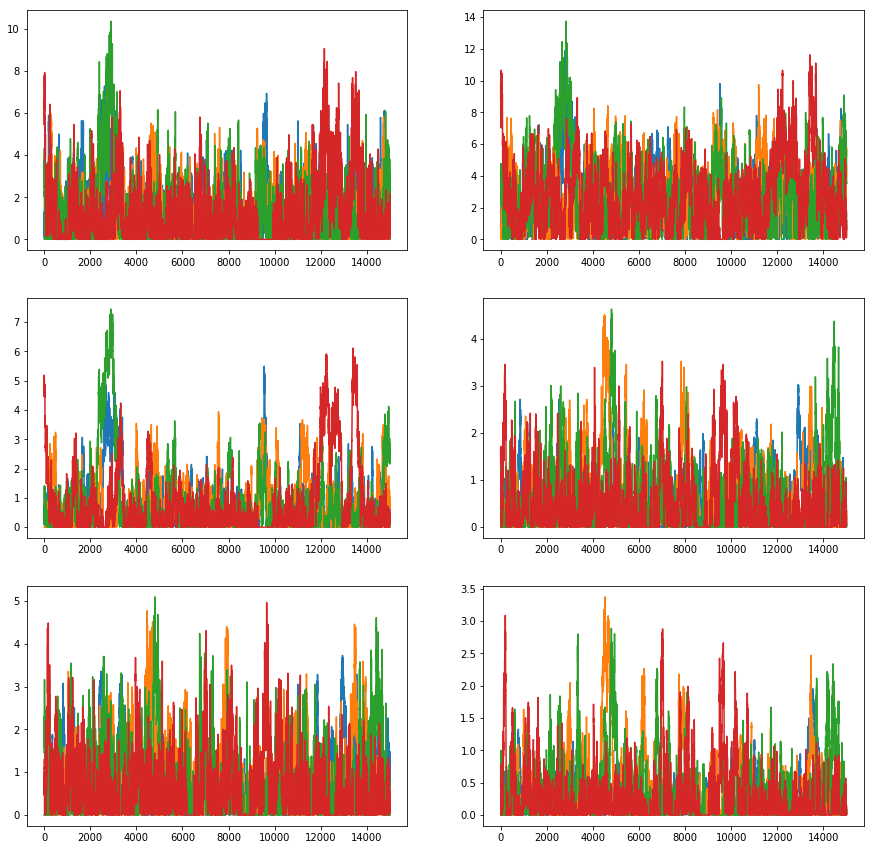

beta


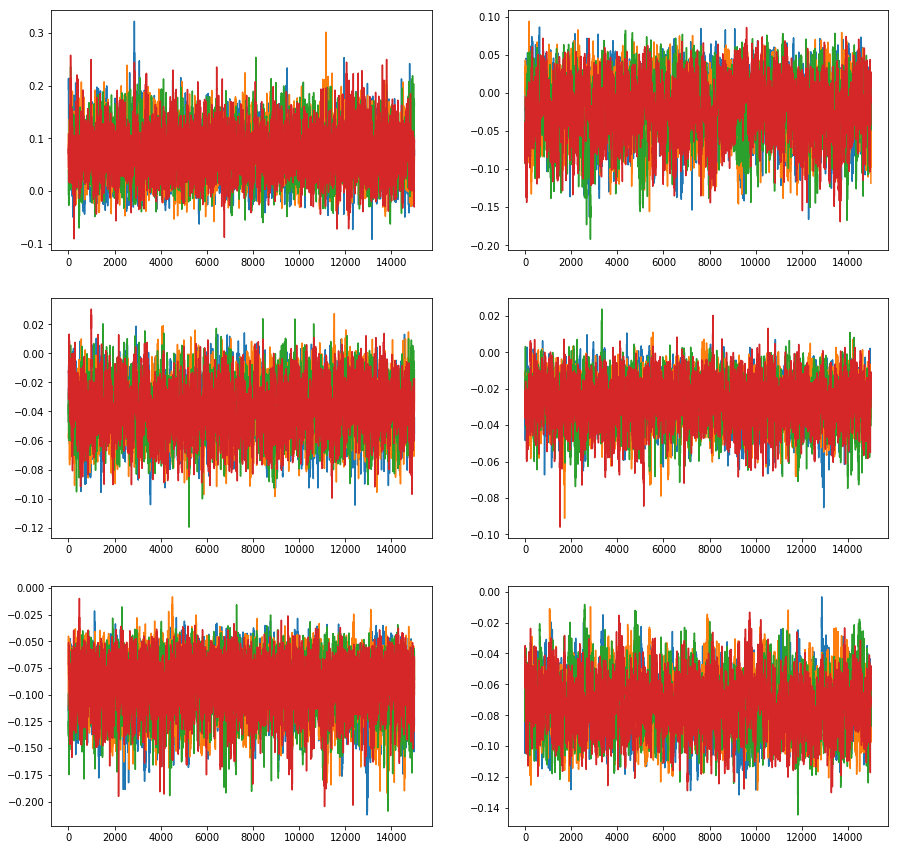

gamma


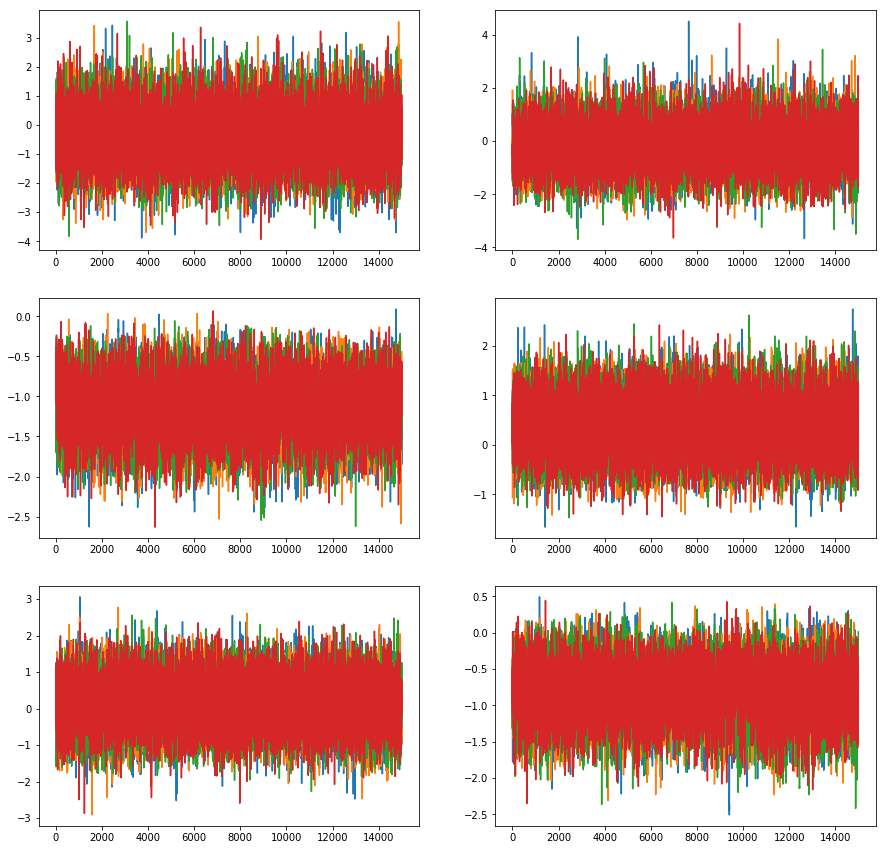

In [29]:
draw(samples, 'alpha1', 2, 2, 2)
draw(samples, 'alpha2', 3, 2, 6)
draw(samples, 'beta', 3, 2, 6)
draw(samples, 'gamma', 3, 2, 6)

In [30]:
def getMeans(samples, name):
    N = len(samples[name])
    x = np.zeros(N)
    for i in range(N):
        x[i] = np.mean(samples[name][i])
    return x

In [31]:
alpha1 = getMeans(samples, 'alpha1')
alpha2 = getMeans(samples, 'alpha2')
beta = getMeans(samples, 'beta')
gamma = getMeans(samples, 'gamma')

In [32]:
print(alpha1)
print(alpha2)
print(beta)
print(gamma)

[ 0.69522034 -0.12305868]
[ 1.0727593   2.51417848  0.73100476  0.52221288  0.65086486  0.29251788]
[ 0.07080758 -0.02220368 -0.03822673 -0.02728125 -0.0917471  -0.07221958]
[-0.37170759 -0.1755163  -1.13096565  0.3872384   0.12024656 -0.81063546]


In [37]:
def predict(Pclass, Age, Sex, SibSp_log):
    global alpha1
    global alpha2
    global beta
    global gamma
    
    grp = 3 * int(Sex) + int(Pclass) - 1
    t = alpha1[int(Sex)] + alpha2[grp] + beta[grp]*Age + gamma[grp]*SibSp_log
    p = 1.0 / (1.0 + math.exp(-t))
    
    if p > 0.5:
        return 1
    else:
        return 0  

In [38]:
predicted = X_train.apply(lambda row: predict(row['Pclass'], row['Age'], row['Sex'], row['SibSp_log']), axis=1)

In [39]:
print('Accuracy', sum(predicted == y_train) / len(y_train))

Accuracy 0.822671156004


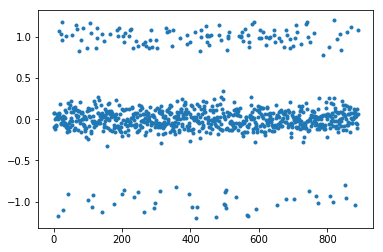

In [40]:
plt.plot(y_train - predicted + np.random.normal(0, 0.1, len(y_train)), '.')

In [41]:
# Prediction for Kaggle

test_predicted = X_test.apply(lambda row: predict(row['Pclass'], row['Age'], row['Sex'], row['SibSp_log']), axis=1)

In [42]:
def writeAnswer(filename, prediction):
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })
    submission.to_csv(filename, index=False)
    
writeAnswer('Hierarchical_2.csv', test_predicted)